## 加载标注文件

In [1]:
import json
with open('/data/workspace/data/annotations.json', 'r') as f:
    annotations = json.load(f)
record_annotations   = annotations['record_annotations']
segment_annotations  = annotations['segment_annotations']
category_annotations = annotations['category_annotations']

## 划分数据集

In [2]:
# 随机挑选2男2女作为测试集
from random import randint, sample
import pandas as pd
import numpy as np

# 第一次随机选择的record_id，可固定用于不同流程的测试
fixed_record_ids_test = \
[1086666360882734668946433344263126473356191873259880785547285261120840322255715262161111808107806375921533268,
278186588382162974895485880364748881102192542708655280918771315963630400228734566106559787234407174254129004884, 1086666360867824382703253768846144030546847669338155775342662464601568789982781373606290761939230874318094676, 16581212781860677470676603355847655857323406269850670126009547093910459715053288150517941521723048542548]

record_ids = [ra['id'] for ra in record_annotations]
record_ids_test = fixed_record_ids_test  # list(set(sample([ra['id'] for ra in record_annotations if ra['gender'] == 'm'], 2))| set(sample([ra['id'] for ra in record_annotations if ra['gender'] == 'f'], 2)))
segment_ids_test = [sa['id'] for sa in segment_annotations if sa['record_id'] in record_ids_test]

In [3]:
print(record_ids_test)

[1086666360882734668946433344263126473356191873259880785547285261120840322255715262161111808107806375921533268, 278186588382162974895485880364748881102192542708655280918771315963630400228734566106559787234407174254129004884, 1086666360867824382703253768846144030546847669338155775342662464601568789982781373606290761939230874318094676, 16581212781860677470676603355847655857323406269850670126009547093910459715053288150517941521723048542548]

[1086666360882734668946433344263126473356191873259880785547285261120840322255715262161111808107806375921533268, 278186588382162974895485880364748881102192542708655280918771315963630400228734566106559787234407174254129004884, 1086666360867824382703253768846144030546847669338155775342662464601568789982781373606290761939230874318094676, 16581212781860677470676603355847655857323406269850670126009547093910459715053288150517941521723048542548]


[1086666360882734668946433344263126473356191873259880785547285261120840322255715262161111808107806375921533268,
 278186588382162974895485880364748881102192542708655280918771315963630400228734566106559787234407174254129004884,
 1086666360867824382703253768846144030546847669338155775342662464601568789982781373606290761939230874318094676,
 16581212781860677470676603355847655857323406269850670126009547093910459715053288150517941521723048542548]

## 流程测试

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.svm import SVC

from nni.feature_engineering.gradient_selector import FeatureGradientSelector

import sys
sys.path.append("/data/workspace/swim")

from select_features import FeatureSelection

df_features = pd.read_csv('/data/workspace/data/features.csv')
# df_features = shuffle(df_features)

rows_test = list(map(lambda x: True if x in segment_ids_test else False, df_features['segment_id']))
rows_test = np.array(rows_test)

df_features_train = df_features.iloc[~rows_test, :]
df_features_test  = df_features.iloc[rows_test, :]

In [5]:
df_features

,Unnamed: 0,Magnetometer Z__abs_energy,Magnetometer Z__absolute_sum_of_changes,"Magnetometer Z__agg_autocorrelation__f_agg_""mean""__maxlag_40","Magnetometer Z__agg_autocorrelation__f_agg_""median""__maxlag_40","Magnetometer Z__agg_autocorrelation__f_agg_""var""__maxlag_40","Magnetometer Z__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","Magnetometer Z__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","Magnetometer Z__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","Magnetometer Z__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,Gyroscope X__variance,Gyroscope X__variance_larger_than_standard_deviation,category,segment_id,Accelerometer Y/Accelerometer X,Accelerometer Z/Accelerometer Y,Accelerometer Z/Accelerometer X,BodyAccelerometer Y/BodyAccelerometer X,BodyAccelerometer Z/BodyAccelerometer Y,BodyAccelerometer Z/BodyAccelerometer X
0,0,475648.243116,314.062486,0.293810,0.343107,0.227077,-13.097205,-0.359450,-1.247296,0.660973,...,53374.091656,1.0,0,0,1.528661,1.705691,1.344308,1.701461,1.459288,1.195670
1,1,424338.705573,312.744127,0.335339,0.348828,0.166901,-26.673927,-0.038455,-0.125100,0.663554,...,62258.787799,1.0,0,0,1.509028,1.788248,1.217851,1.886620,1.576423,1.121296
2,2,401479.658820,300.292956,0.352510,0.403554,0.212224,-8.663862,-0.451855,-1.400491,0.564397,...,54298.020990,1.0,0,0,1.457010,1.590161,1.215718,1.905907,1.532640,1.167514
3,3,361778.550571,275.537098,0.369331,0.398972,0.183333,-27.688049,0.102711,0.338241,0.668651,...,51147.590087,1.0,0,0,1.426425,1.656612,1.202936,1.762638,1.439091,1.156292
4,4,365522.806796,272.607409,0.422226,0.480391,0.177792,-5.094401,-0.460424,-1.506661,0.592950,...,49204.948218,1.0,0,0,1.377419,1.536719,1.256388,1.777323,1.437811,1.177192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8934,8934,824189.751123,115.429683,0.562529,0.535952,0.061559,-44.095551,-0.380147,-0.687500,0.341447,...,6417.376854,1.0,1,268,1.061120,1.068223,1.189251,1.414243,1.244841,1.590345
8935,8935,801126.466146,107.958978,0.600528,0.557749,0.050335,-66.577771,0.643436,1.110627,0.269714,...,4826.979774,1.0,1,268,1.008961,1.077309,1.180908,1.418314,1.246871,1.478176
8936,8936,603692.706264,133.154288,0.409964,0.402160,0.138938,-46.688449,0.123943,0.202774,0.331377,...,4357.383821,1.0,1,268,1.090958,1.111361,1.375445,1.383271,1.218533,1.533665
8937,8937,568199.467766,116.601556,0.470384,0.494854,0.125055,-48.382410,0.237566,0.373898,0.312067,...,4204.643408,1.0,1,268,1.183167,0.902533,1.444799,1.514290,0.961727,1.596441


In [11]:
# 流程一：以2.56s为窗口切分数据，仅使用3轴加速度计数据
X_columns = [c for c in df_features.columns if c[:13] == 'Accelerometer']
y_columns = ['category']

X_train, y_train = df_features_train.loc[:, X_columns].values, df_features_train.loc[:, y_columns].values
X_test, y_test   = df_features_test.loc[:, X_columns].values, df_features_test.loc[:, y_columns].values

pipeline = make_pipeline(StandardScaler(), FeatureGradientSelector(n_features=20, preprocess=False, n_epochs=2), LogisticRegression())
fs = FeatureSelection(pipeline=pipeline)
fs.fit(X_train, y_train)

print(fs.score(X_test, y_test))
print(fs.get_selected_features(feature_columns=X_columns, feature_selector_index=1))

0.9314535731648032
[1459 1510 1511 1516 1524 1562 1563 1564 1565 1583 1770 2170 2171 2174
 2208 2209 2212 2214 2230 2260] <class 'numpy.ndarray'>
['Accelerometer Y__range_count__max_1__min_-1'
 'Accelerometer Z__agg_autocorrelation__f_agg_"mean"__maxlag_40'
 'Accelerometer Z__agg_autocorrelation__f_agg_"median"__maxlag_40'
 'Accelerometer Z__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'Accelerometer Z__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"'
 'Accelerometer Z__approximate_entropy__m_2__r_0.3'
 'Accelerometer Z__approximate_entropy__m_2__r_0.5'
 'Accelerometer Z__approximate_entropy__m_2__r_0.7'
 'Accelerometer Z__approximate_entropy__m_2__r_0.9'
 'Accelerometer Z__autocorrelation__lag_9'
 'Accelerometer Z__fft_coefficient__coeff_1__attr_"abs"'
 'Accelerometer Z__linear_trend__attr_"stderr"'
 'Accelerometer Z__longest_strike_above_mean' 'Accelerometer Z__maximum'
 'Accelerometer Z__quantile__q_0.7' 'Accelerometer Z__quantile__q_0.8'
 'Accelerometer Z_

In [65]:
# 流程二: 以2.56s为窗口切分数据，使用3轴身体加速度计数据
X_columns = [c for c in df_features.columns if c[:4] == 'Body']
y_columns = ['category']

X_train, y_train = df_features_train.loc[:, X_columns].values, df_features_train.loc[:, y_columns].values
X_test, y_test   = df_features_test.loc[:, X_columns].values, df_features_test.loc[:, y_columns].values

pipeline = make_pipeline(StandardScaler(), FeatureGradientSelector(n_features=20, preprocess=False, n_epochs=2), LogisticRegression())
fs = FeatureSelection(pipeline=pipeline)
fs.fit(X_train, y_train)

print(fs.score(X_test, y_test))
print(fs.get_selected_features(feature_columns=X_columns, feature_selector_index=1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
0.8721438988818668
[   0    2    3    4   54   55   56   57   75  662  664  722  752  808
  809  810  811 1465 1562 1724] <class 'numpy.ndarray'>
['BodyAccelerometer Z__abs_energy'
 'BodyAccelerometer Z__agg_autocorrelation__f_agg_"mean"__maxlag_40'
 'BodyAccelerometer Z__agg_autocorrelation__f_agg_

In [7]:
# 流程三: 以2.56s为窗口切分数据，使用3轴加速度数据和3轴陀螺仪数据
X_columns = [c for c in df_features.columns if c[:13] == 'Accelerometer' or c[:9] == 'Gyroscope']
y_columns = ['category']

X_train, y_train = df_features_train.loc[:, X_columns].values, df_features_train.loc[:, y_columns].values
X_test, y_test   = df_features_test.loc[:, X_columns].values, df_features_test.loc[:, y_columns].values

pipeline = make_pipeline(StandardScaler(), FeatureGradientSelector(n_features=100, preprocess=False, n_epochs=2), LogisticRegression())
fs = FeatureSelection(pipeline=pipeline)
fs.fit(X_train, y_train)

print(fs.score(X_test, y_test))
print(fs.get_selected_features(feature_columns=X_columns, feature_selector_index=1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
0.9732620320855615
[  54  217  306  674  717  756  757  808  809  810  811  812  818  824
  825  826  827  828  829  849  973  975 1421 1425 1426 1452 1453 1458
 1471 1479 1562 1563 1564 1565 1567 1575 1649 1722 1724 1725 2128 2192
 2193 2213 2261 2262 2264 2265 2266 2270 2271 2274 2278 2282 2286 22

In [66]:
# 流程五: 以2.56秒为窗口，25hz为采样率，采用三轴加速度数据
df_features = pd.read_csv('/data/workspace/data/features_25hz.csv')
# df_features = shuffle(df_features)

rows_test = list(map(lambda x: True if x in segment_ids_test else False, df_features['segment_id']))
rows_test = np.array(rows_test)

df_features_train = df_features.iloc[~rows_test, :]
df_features_test  = df_features.iloc[rows_test, :]

In [69]:
X_columns = [c for c in df_features.columns if c[:13] == 'Accelerometer']
y_columns = ['category']

X_train, y_train = df_features_train.loc[:, X_columns].values, df_features_train.loc[:, y_columns].values
X_test, y_test   = df_features_test.loc[:, X_columns].values, df_features_test.loc[:, y_columns].values

pipeline = make_pipeline(StandardScaler(), FeatureGradientSelector(n_features=20, preprocess=False, n_epochs=2), LogisticRegression())
fs = FeatureSelection(pipeline=pipeline)
fs.fit(X_train, y_train)

print(fs.score(X_test, y_test))
print(fs.get_selected_features(feature_columns=X_columns, feature_selector_index=1))

0.9390541199414919
[  20  306  705  753 1060 1517 1576 1577 1578 1595 1610 1611 1617 1649
 1724 1770 2171 2174 2214 2230] <class 'numpy.ndarray'>
['Accelerometer Y__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'Accelerometer Y__fft_coefficient__coeff_2__attr_"abs"'
 'Accelerometer Y__range_count__max_1__min_-1'
 'Accelerometer Y__variance_larger_than_standard_deviation'
 'Accelerometer X__fft_coefficient__coeff_2__attr_"abs"'
 'Accelerometer Z__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'Accelerometer Z__autocorrelation__lag_2'
 'Accelerometer Z__autocorrelation__lag_3'
 'Accelerometer Z__autocorrelation__lag_4'
 'Accelerometer Z__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2'
 'Accelerometer Z__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2'
 'Accelerometer Z__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4'
 'Accelerometer Z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8'
 'Accelerometer Z__cid_ce

## 流程分析

In [5]:
df_record = pd.read_csv('/data/workspace/data/records/TAS1F39170063 (2019-06-15)-IMU_huangzihui.csv')
accZ = df_record['Accelerometer Z']

In [17]:
# 分析1: 为何在去除低频分量后，准确率会出现下降
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal

sos = signal.butter(4, 0.25, 'lp', fs=100, output='sos')
f = signal.sosfilt(sos, accZ)

fig = plt.figure(figsize=(40, 8))
ax = fig.add_subplot(111)
ax.plot(f)
ax.set_xlim(0, 90000)
ax.set_xlabel('Time [s]', size=28)
ax.set_xticklabels(fontsize=28)
ax.set_ylabel('Accelerometer Z', size=28)

plt.title('Accelerometer Z after 0.25Hz Low-Pass Filtering', size=36)

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

In [8]:
# 分析2: 25Hz采样率，2.56s窗口，采用3轴加速度的结果分析
df_features = pd.read_csv('/data/workspace/data/features_25hz.csv')

rows_test = list(map(lambda x: True if x in segment_ids_test else False, df_features['segment_id']))
rows_test = np.array(rows_test)

df_features_train = df_features.iloc[~rows_test, :]
df_features_test  = df_features.iloc[rows_test, :]

In [9]:
X_columns = [c for c in df_features.columns if c[:13] == 'Accelerometer']
y_columns = ['category']

X_train, y_train = df_features_train.loc[:, X_columns].values, df_features_train.loc[:, y_columns].values
X_test, y_test   = df_features_test.loc[:, X_columns].values, df_features_test.loc[:, y_columns].values

c_index = [20, 306, 705, 753, 1060, 1517, 1576, 1577, 1578, 1595, 1610, 1611, 1617, 1649, 1724, 1770, 2171, 2174, 2214, 2230]
X_train = X_train[:, c_index]
X_test = X_test[:, c_index]

pipeline = make_pipeline(StandardScaler(), LogisticRegression())
pipeline.fit(X_train, y_train)

y_test_preds = pipeline.predict(X_test, y_test)

0.9390541199414919
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [12]:
from sklearn.metrics import confusion_matrix
y_test_preds = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_test_preds)

Normalized confusion matrix
[[0.9658444  0.00759013 0.02087287 0.0056926 ]
 [0.01398601 0.97027972 0.00874126 0.00699301]
 [0.04183267 0.04780876 0.88844622 0.02191235]
 [0.00222222 0.01333333 0.06       0.92444444]]


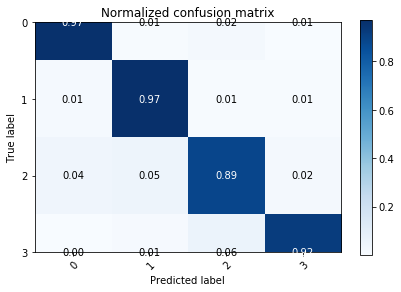

In [17]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    # Only use the labels that appear in the data
    #     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

plot_confusion_matrix(np.array(cm), classes=range(4))

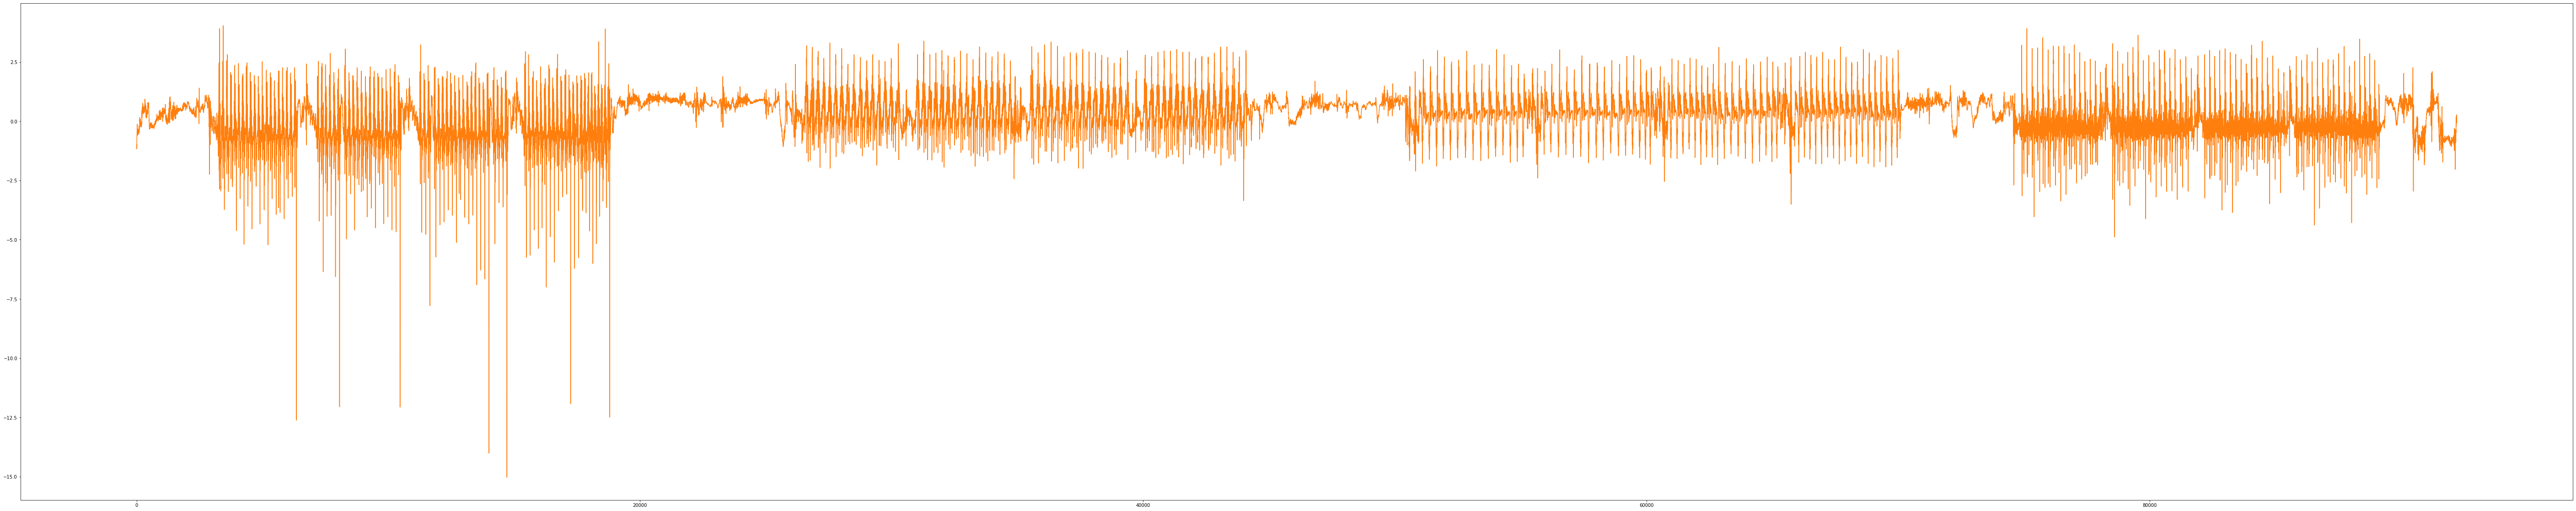

In [10]:
b, a = signal.butter(10, 0.25/50, 'lowpass')   #配置滤波器 8 表示滤波器的阶数
f = signal.filtfilt(b, a, accX)  #data为要过滤的信号
fig = plt.figure(figsize=(100, 20))
ax = fig.add_subplot(111)
ax.plot(f)
ax.plot(accX)
plt.show()